# Imports

In [1]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation,Dropout,Flatten,Dense
from keras import backend as K
from keras import regularizers

import numpy as np
from keras.preprocessing import image
import tensorflow.keras.metrics

import matplotlib.pyplot as plt

import pandas as pd
import os
import shutil
import sys

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.random.set_seed(1983)

# Variable definitions

In [3]:

image_width,img_height = 64,64

train_data_dir = 'morel_classifier_images/train'
test_data_dir = 'morel_classifier_images/test'

nb_train_samples = 200
nb_test_samples = 20

epochs = 60
batch_size = 81 # Use powers of 2

# Generate the data from the images

In [4]:
if K.image_data_format() =='channels_first':
    input_shape = (3,image_width,img_height)
else:
    input_shape = (image_width,img_height,3)

In [5]:
train_datagen = ImageDataGenerator(
                            rescale= (1.0 /255),
                            shear_range =0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip= True
                                    )

In [6]:
test_datagen = ImageDataGenerator( rescale= 1.0/255)

In [7]:
train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,
                                                    target_size=(image_width,img_height),
                                                    batch_size=batch_size,
                                                    class_mode = 'binary'
                                                    )

Found 1740 images belonging to 2 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
                                                test_data_dir,
                                                target_size=(image_width,img_height),
                                                batch_size=batch_size,
                                                class_mode='binary'
                                                    )

Found 616 images belonging to 2 classes.


# Start the model

In [9]:
model = Sequential()

In [10]:
# First layer - input image
model.add(Conv2D(255,
                 kernel_size= (3,3), 
                 input_shape=input_shape, 
                 activation='relu',
                ))
model.add(MaxPooling2D(pool_size=(2,2)))

In [11]:
# hidden layers
model.add(Conv2D(128,
                 kernel_size=(3,3),
                 activation='relu',
                ))
model.add(Dropout(.1))
model.add(MaxPooling2D(pool_size=(2,2)))

In [12]:
model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu',
                ))
model.add(Dropout(.1))
model.add(MaxPooling2D(pool_size=(2,2)))

In [13]:
model.add(Conv2D(32,
                 kernel_size=(3,3),
                 activation='relu',
                ))
model.add(Dropout(.1))
model.add(MaxPooling2D(pool_size=(2,2)))

In [14]:
# flatten
model.add(Flatten(input_shape=input_shape))


In [15]:
# Dense Layers
model.add(Dense(64, 
                activation='relu',
               ))
model.add(Dropout(.1))

model.add(Dense(32, 
                activation='relu',
               ))
model.add(Dropout(.1))

model.add(Dense(25, 
                activation='relu',
               ))
model.add(Dropout(.1))

In [16]:
# final output layer
model.add(Dense(1, activation = 'sigmoid'))

In [17]:
model.compile( 
    loss = 'binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
                )

In [18]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch= nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=nb_test_samples // batch_size,
            verbose = 0
)

model.save('history/morel_class_try.h5')

# Plot the data

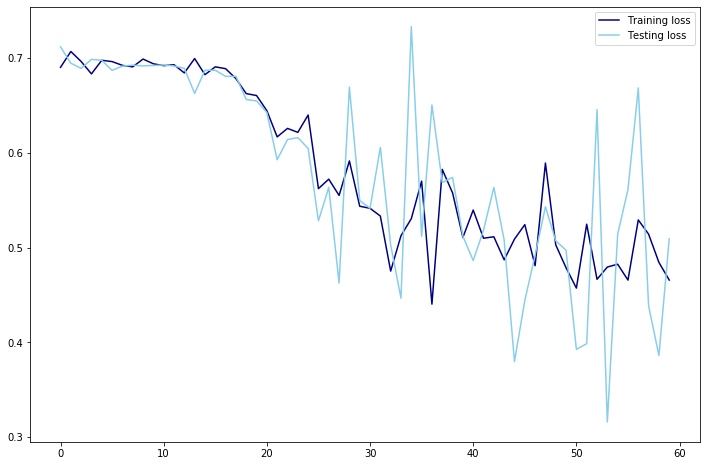

In [19]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend()
plt.savefig('figures/morel_loss.png');

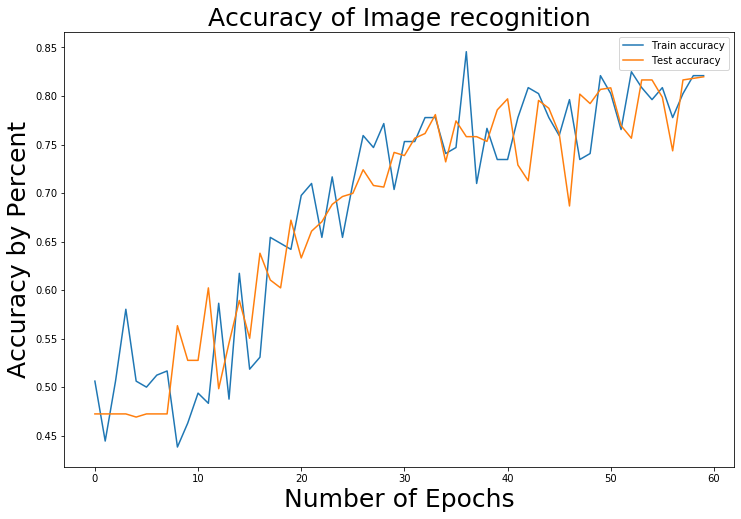

In [20]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend()
plt.title("Accuracy of Image recognition", fontsize=25)
plt.xlabel("Number of Epochs", fontsize=25)
plt.ylabel("Accuracy by Percent", fontsize=25)
plt.savefig('figures/morel_acc.png');

# Test single image

In [21]:
# img_pred = image.load_img('morel_classifier_images/Test/1_not_good_morels/OIP - 2020-03-04T145542.245.jpeg',
#                           target_size=(img_height,image_width))

# img_pred = image.img_to_array(img_pred)
# img_pred = np.expand_dims(img_pred, axis = 0)

In [22]:
# result = model.predict_classes(img_pred)

In [23]:
# print(result)

In [24]:
# if result[0][0] == 1:
#     prediction = 'bad morel bad'
# else:
#     prediction = 'good morel'
    
# print(prediction)

# Make Predictions on False Mushrooms

In [25]:
#Create list for each image to be predicted on
false_folder_list = sorted(os.listdir(f'morel_classifier_images/Test/1_not_good_morels'))
false_folder_list[:5]

['.DS_Store',
 'OIP - 2020-03-04T145542.245.jpeg',
 'OIP - 2020-03-04T145542.255.jpeg',
 'OIP - 2020-03-04T145542.272.jpeg',
 'OIP - 2020-03-04T145542.276.jpeg']

In [26]:
# Remove system/hidden files from the list so predictions aren't made on them
try:
    false_folder_list.remove('.DS_Store')
    false_folder_list.remove('.ipynb_checkpoints')
except:
    print('item not removed from folder list')

item not removed from folder list


In [27]:
false_folder_list[:5]

['OIP - 2020-03-04T145542.245.jpeg',
 'OIP - 2020-03-04T145542.255.jpeg',
 'OIP - 2020-03-04T145542.272.jpeg',
 'OIP - 2020-03-04T145542.276.jpeg',
 'OIP - 2020-03-04T145542.279.jpeg']

In [28]:
false_preds = []
false_proba = []
counter=0
for i in false_folder_list[:]:
    # Read each image from the testing - bad morels folder and generate/save predictions
    try:
        img_path =(f'morel_classifier_images/Test/1_not_good_morels/{i}')

        img_pred = image.load_img(img_path,target_size=(img_height,image_width))
        img_pred = image.img_to_array(img_pred)
        img_pred = np.expand_dims(img_pred, axis = 0)

        
        false_preds.append(int(model.predict_classes(img_pred)))
        false_proba.append(float(model.predict(img_pred)))
        
        counter += 1
    # if there is an error assign a 3 to the error in the list so we can find it in EDA steps    
    except:
        print(f'error on {counter}')
        false_preds.append(3)
        false_proba.append(3)

In [29]:
false_preds[:10]

[1, 1, 1, 0, 1, 0, 1, 1, 1, 0]

In [30]:
false_proba[:10]

[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]

    Convert predictions into a dataframe

In [31]:
false_predictions_df = pd.DataFrame(false_preds, columns =["predictions"])
false_predictions_df.head()

,predictions
0,1
1,1
2,1
3,0
4,1


In [32]:
false_probas_df = pd.DataFrame(false_proba, columns =["predictions_proba"])
false_probas_df.head()

,predictions_proba
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0


In [33]:
# test to find if any results are 'unclassified'
false_predictions_df.loc[false_predictions_df['predictions']==3]

,predictions


In [34]:
# test to find if any results are 'unclassified'
false_probas_df.loc[false_probas_df['predictions_proba']==3]

,predictions_proba


In [35]:
false_file_name = pd.DataFrame(false_folder_list, columns=['file_name'])

    Combined file name, prediction , and predict proba data frames

In [36]:
false_predictions_df = pd.concat([false_file_name,false_predictions_df,false_probas_df],axis=1)

In [37]:
false_predictions_df['actual_mushroom_type'] = 1
false_predictions_df['Type'] = 'false_morel'

In [38]:
false_predictions_df.head()

,file_name,predictions,predictions_proba,actual_mushroom_type,Type
0,OIP - 2020-03-04T145542.245.jpeg,1,1.0,1,false_morel
1,OIP - 2020-03-04T145542.255.jpeg,1,1.0,1,false_morel
2,OIP - 2020-03-04T145542.272.jpeg,1,1.0,1,false_morel
3,OIP - 2020-03-04T145542.276.jpeg,0,0.0,1,false_morel
4,OIP - 2020-03-04T145542.279.jpeg,1,1.0,1,false_morel


In [39]:
false_predictions_df.shape

(325, 5)

# Make Predictions on Good Mushrooms

In [40]:
#Create list for each image to be predicted on
true_folder_list = sorted(os.listdir('morel_classifier_images/Test/0_good_morels'))
true_folder_list[:5]

['.DS_Store',
 'OIP (100).jpeg',
 'OIP (64).jpeg',
 'OIP (65).jpeg',
 'OIP (66).jpeg']

In [41]:
# Remove system/hidden files from the list so predictions aren't made on them
try:
    true_folder_list.remove('.DS_Store')
    true_folder_list.remove('.ipynb_checkpoints')
except:
    print('item not removed from folder list')

item not removed from folder list


In [42]:
true_folder_list[:5]

['OIP (100).jpeg',
 'OIP (64).jpeg',
 'OIP (65).jpeg',
 'OIP (66).jpeg',
 'OIP (67).jpeg']

In [43]:
true_preds = []
true_proba = []
counter=0
for i in true_folder_list[:]:
    # Read each image from the testing - good morels folder and generate/save predictions
    try:
        image_list = []
        img_path =(f'morel_classifier_images/Test/0_good_morels/{i}')

        img_pred = image.load_img(img_path,target_size=(img_height,image_width))
        img_pred = image.img_to_array(img_pred)
        img_pred = np.expand_dims(img_pred, axis = 0)
        

        true_preds.append(int(model.predict_classes(img_pred)))
        true_proba.append(float(model.predict(img_pred)))
        counter += 1
    # if there is an error assign a 3 to the error in the list so we can find it in EDA steps
    except:
        print(f'error on {counter}')
        true_preds.append(3)
        true_proba.append(3)

In [44]:
true_preds[:10]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [45]:
true_proba[:10]

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

    Convert predictions into a dataframe

In [46]:
true_predictions_df = pd.DataFrame(true_preds, columns =["predictions"])
true_predictions_df.head()

,predictions
0,0
1,0
2,1
3,0
4,0


In [47]:
true_probas_df = pd.DataFrame(true_proba, columns = ["predictions_proba"])
true_probas_df.head()

,predictions_proba
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [48]:
# test to find if any results are 'unclassified'
true_predictions_df.loc[true_predictions_df['predictions']==3]

,predictions


In [49]:
true_probas_df.loc[true_probas_df["predictions_proba"]==3]

,predictions_proba


In [50]:
true_file_name = pd.DataFrame(true_folder_list, columns=['file_name'])

    Combined file name, prediction , and predict proba data frames

In [51]:
true_predictions_df = pd.concat([true_file_name,true_predictions_df,true_probas_df],axis=1)

In [52]:
true_predictions_df['actual_mushroom_type'] = 0
true_predictions_df['Type'] = 'true_morel'

In [53]:
true_predictions_df.head()

,file_name,predictions,predictions_proba,actual_mushroom_type,Type
0,OIP (100).jpeg,0,0.0,0,true_morel
1,OIP (64).jpeg,0,0.0,0,true_morel
2,OIP (65).jpeg,1,1.0,0,true_morel
3,OIP (66).jpeg,0,0.0,0,true_morel
4,OIP (67).jpeg,0,0.0,0,true_morel


    Merge Data frames and export to CSV

In [54]:
final_df = pd.concat([true_predictions_df,false_predictions_df])

In [55]:
final_df['actual_mushroom_type'].value_counts()

1    325
0    291
Name: actual_mushroom_type, dtype: int64

In [56]:
final_df['predictions'].value_counts()

0    314
1    302
Name: predictions, dtype: int64

In [57]:
final_df.to_csv('CSVs/Pred_True_vs_false.csv', index=False)